## Cài đặt các thư viện cần thiết

In [43]:
!pip install opencv-python
!pip install tensorflow
!pip install keras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Import các thư viện cần thiết

In [44]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import cv2

## Đọc dữ liệu và hiển thị các thông tin cơ bản

In [45]:
DATASET_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/"
print(os.listdir(DATASET_PATH))

# Đọc file styles.csv
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=40000, on_bad_lines='skip')
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

['images.csv', 'images', 'styles.csv', 'styles', 'fashion-dataset']


## Định nghĩa các hàm xử lý ảnh

In [47]:
# Hàm lấy đường dẫn đầy đủ của ảnh
def img_path(img):
    return os.path.join(DATASET_PATH, "images", img)

# Hàm load ảnh gốc không thay đổi kích thước
def load_image_no_resize(img):
    img_full_path = img_path(img)
    img = cv2.imread(img_full_path)
    if img is not None:
        return img
    else:
        print(f"Warning: Unable to load image {img}")
        return None

# Hàm load ảnh và thay đổi kích thước
def load_image_resized(img, resized_fac=0.5):
    img_full_path = img_path(img)
    img = cv2.imread(img_full_path)
    if img is not None:
        h, w, _ = img.shape
        resized = cv2.resize(img, (int(w * resized_fac), int(h * resized_fac)), interpolation=cv2.INTER_LINEAR)
        return resized
    else:
        print(f"Warning: Unable to load image {img}")
        return None

# Hàm hiển thị nhiều ảnh
def plot_figures(figures, nrows=1, ncols=1, figsize=(12, 8), dpi=150):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    for i, (title, img) in enumerate(figures.items()):
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')
        else:
            axes[i].set_title(title, fontsize=10)
            axes[i].text(0.5, 0.5, 'Image not found', ha='center', va='center')
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

## Kiểm tra kích thước và hiện thị các ảnh

In [ ]:
# Kiểm tra kích thước ảnh gốc
print("Original sizes of first 5 images:")
for i in range(5):
    img_name = df.iloc[i]['image']
    img = load_image_no_resize(img_name)
    if img is not None:
        print(f"{img_name}: {img.shape}")  # (height, width, channels)
    else:
        print(f"{img_name}: Image not loaded")

# Hiển thị ảnh gốc không thay đổi kích thước
figures_no_resize = {}
sample_df = df.sample(6).reset_index(drop=True)

for i, row in sample_df.iterrows():
    img = load_image_no_resize(row['image'])
    if img is not None:
        figures_no_resize[f"Image {i}"] = img

plot_figures(figures_no_resize, nrows=2, ncols=3, figsize=(12, 8), dpi=150)

Original sizes of first 5 images:
15970.jpg: (2400, 1800, 3)
39386.jpg: (2400, 1800, 3)
59263.jpg: (1440, 1080, 3)
21379.jpg: (2400, 1800, 3)
53759.jpg: (1440, 1080, 3)


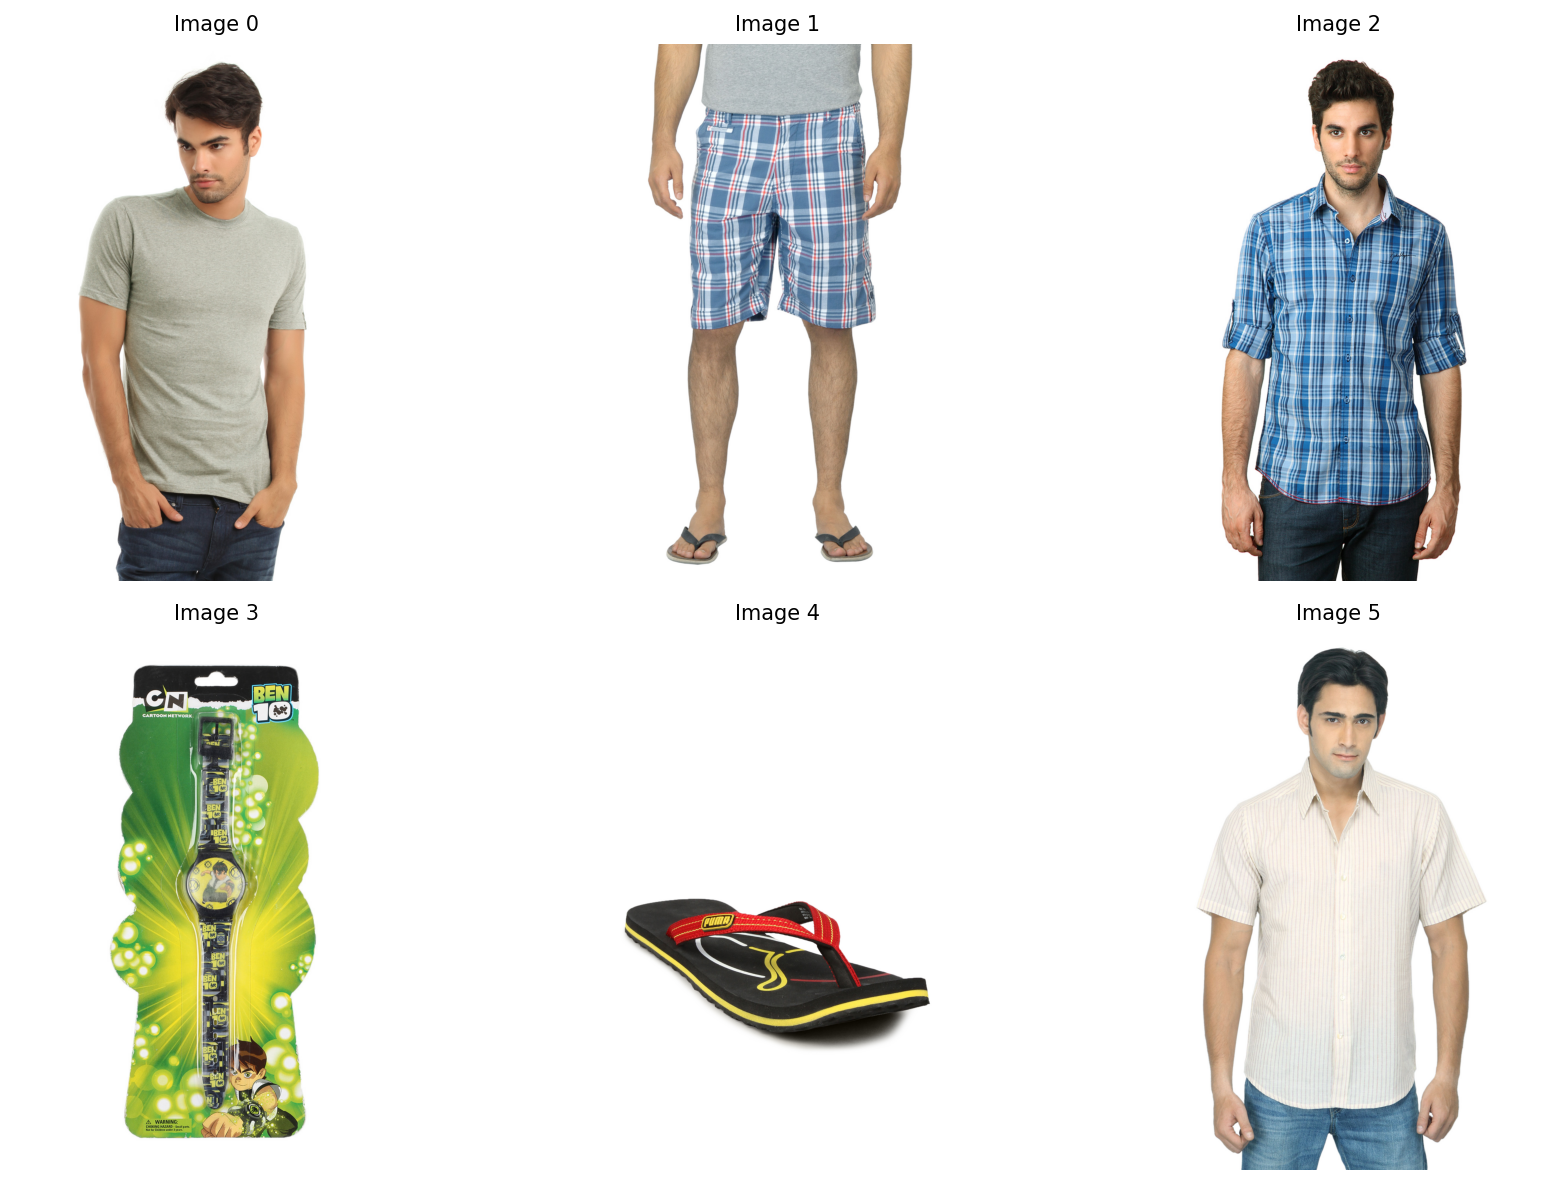

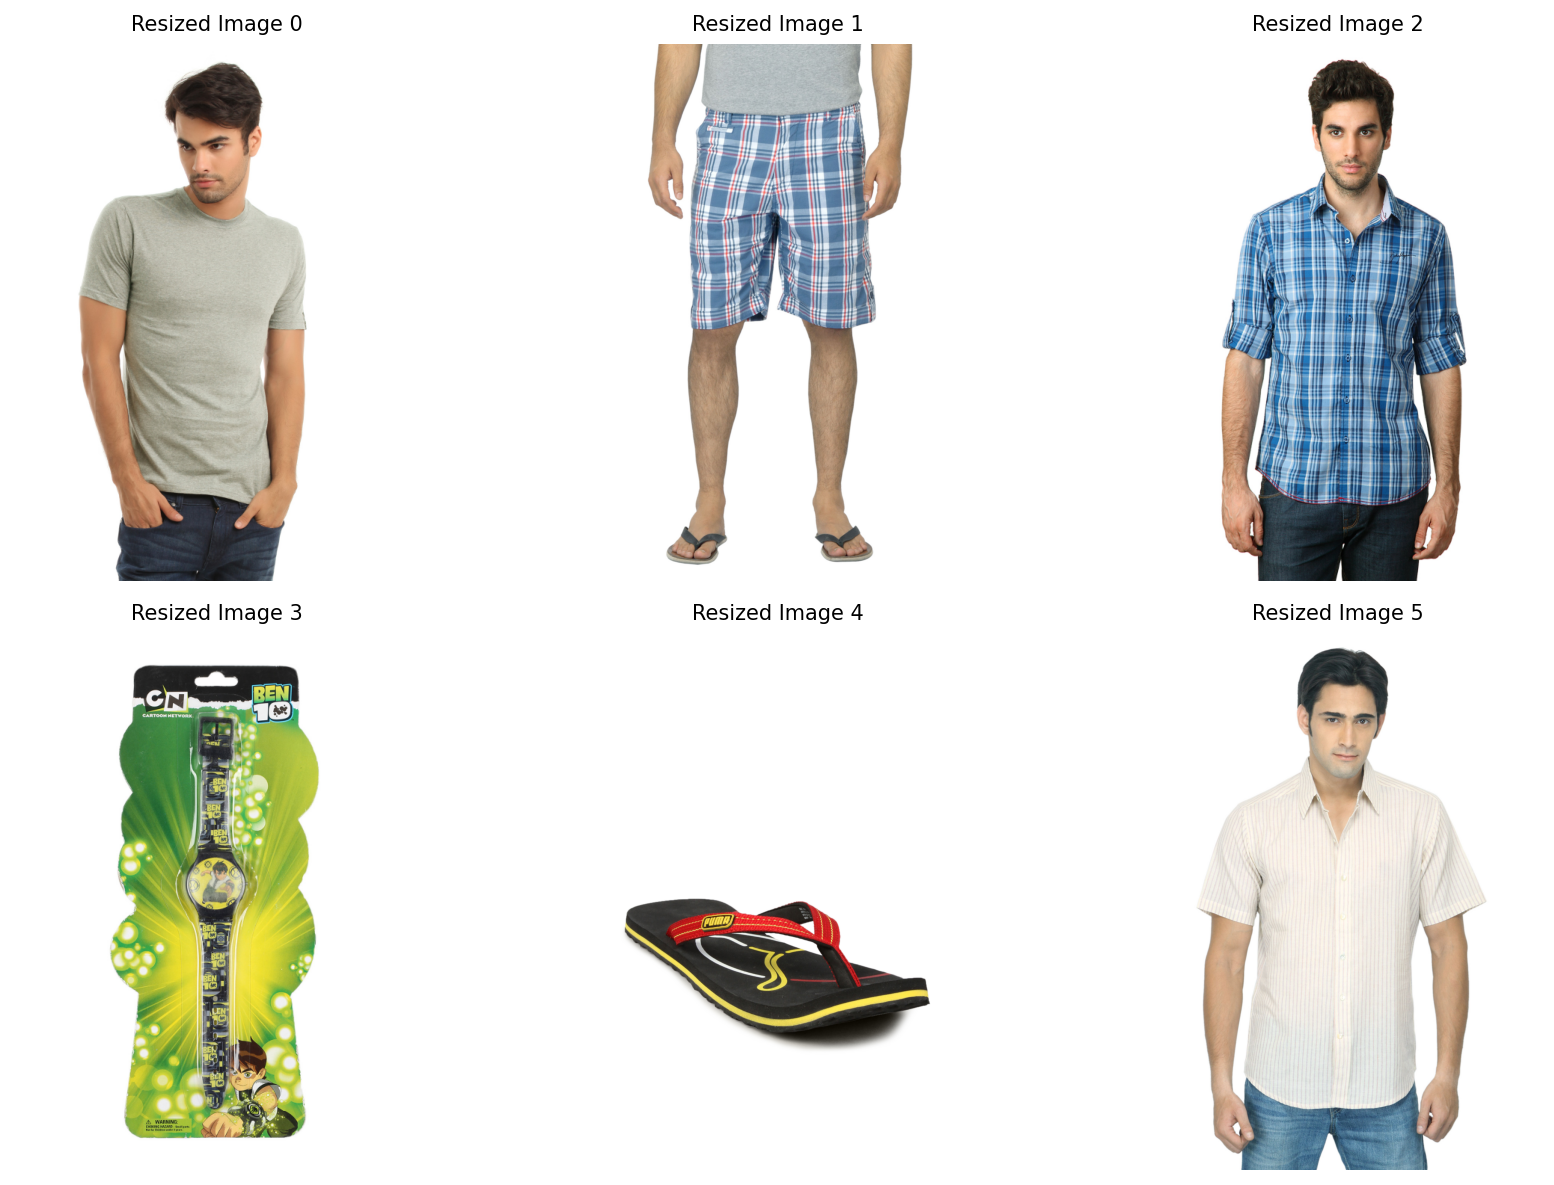

In [50]:
# Hiển thị ảnh đã thay đổi kích thước
figures_resized = {}
for i, row in sample_df.iterrows():
    img = load_image_resized(row['image'], resized_fac=0.5)
    if img is not None:
        figures_resized[f"Resized Image {i}"] = img

plot_figures(figures_resized, nrows=2, ncols=3, figsize=(12, 8), dpi=150)

## Biểu đồ phân bố loại sản phẩm

<Axes: ylabel='articleType'>

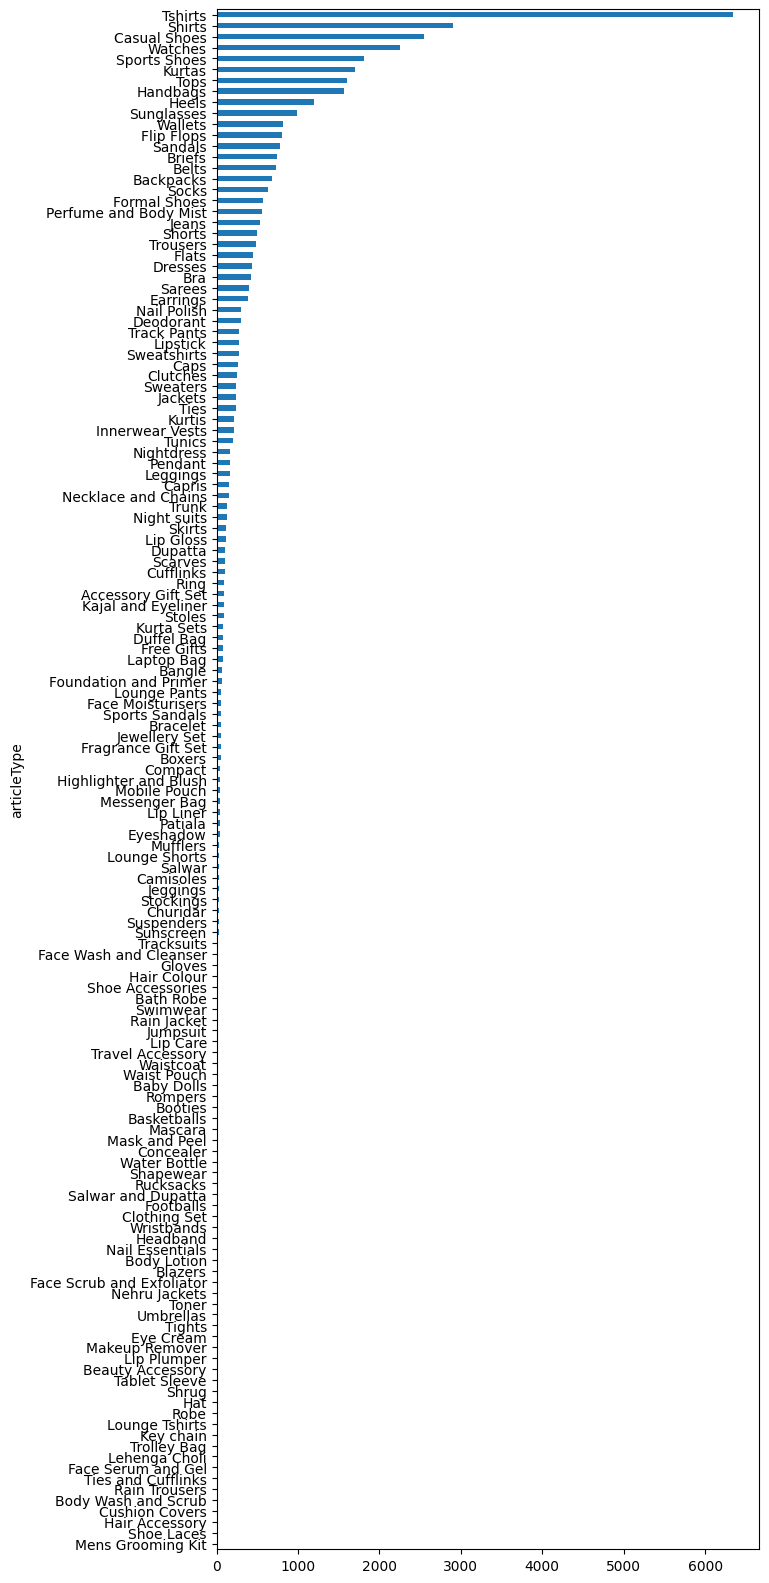

In [51]:
plt.figure(figsize=(7,20))

df.articleType.value_counts().sort_values().plot(kind='barh')

## Xây dựng mô hình ResNet50 để tạo embedding ảnh

In [55]:
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalMaxPooling2D
from keras.applications.resnet50 import preprocess_input, image

# Khởi tạo mô hình ResNet50
img_width, img_height, _ = 224, 224, 3
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

# Thêm tầng GlobalMaxPooling2D để lấy embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

# Hiển thị cấu trúc mô hình
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [56]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

## Hàm tạo embedding cho ảnh

In [57]:
def get_embedding(model, img_name):
    try:
        img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return model.predict(x).reshape(-1)
    except Exception as e:
        print(f"Error processing {img_name}: {e}")
        return np.nan

## Tính toán embedding cho toàn bộ dataset

In [ ]:
map_embeddings = df_filtered['image'].apply(lambda img: get_embedding(model, img))
df_embs = map_embeddings.apply(pd.Series)
df_clean = df_embs.dropna()
print(df_embs.shape)
print(df_clean.shape)
df_clean.head(10)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.4 µs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

## Tính toán ma trận khoảng cách Cosine Similarity

In [96]:
from sklearn.metrics.pairwise import pairwise_distances

cosine_sim = 1 - pairwise_distances(df_clean, metric='cosine')
cosine_sim[:4, :4]

array([[0.999999  , 0.7128042 , 0.45375043, 0.67937243],
       [0.7128042 , 0.9999996 , 0.41515315, 0.833309  ],
       [0.45375043, 0.41515315, 0.99999905, 0.44629478],
       [0.67937243, 0.833309  , 0.44629478, 0.9999994 ]], dtype=float32)

## Hiển thị kết quả embedding và các gợi ý tương tự

In [98]:
# Hàm gợi ý dựa trên Cosine Similarity
def get_recommender(idx, df_clean, top_n=5):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n + 1]
    idx_rec = [i[0] for i in sim_scores]
    return idx_rec

In [ ]:
# Lấy gợi ý và hiển thị
idx_ref = 2993
idx_rec = get_recommender(idx_ref, df_clean, top_n=6)

plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
figures = {'im' + str(i): load_image(df.iloc[idx].image) for idx in idx_rec}
plot_figures(figures, 2, 3)

In [ ]:
# Lấy gợi ý và hiển thị
idx_ref = 878
idx_rec = get_recommender(idx_ref, df_clean, top_n=6)

plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
figures = {'im' + str(i): load_image(df.iloc[idx].image) for idx in idx_rec}
plot_figures(figures, 2, 3)

In [ ]:
# Lấy gợi ý và hiển thị
idx_ref = 987
idx_rec = get_recommender(idx_ref, df_clean, top_n=6)

plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
figures = {'im' + str(i): load_image(df.iloc[idx].image) for idx in idx_rec}
plot_figures(figures, 2, 3)

## # Tạo dữ liệu kết hợp từ thông tin bảng và embedding ảnh

In [6]:
# Kết hợp các thông tin từ dữ liệu gốc và embedding
df_filtered['tsne-2d-one'] = tsne_results[:, 0]
df_filtered['tsne-2d-two'] = tsne_results[:, 1]

# Kết hợp bảng dữ liệu với embedding ảnh
df_combined = pd.concat([df_filtered, df_clean], axis=1)

# Xóa các cột không cần thiết
df_combined.drop(['tsne-2d-one', 'tsne-2d-two', 'image', 'id'], axis=1, inplace=True)
df_combined.drop(['productDisplayName'], axis=1, inplace=True)

# Kiểm tra kích thước của bảng dữ liệu kết hợp
print("Kích thước của dữ liệu kết hợp:", df_combined.shape)

NameError: name 'tsne_results' is not defined

## Biến đổi dữ liệu dạng phân loại thành one-hot encoding

In [ ]:
# Các cột phân loại cần chuyển đổi
categorical_columns = ['gender', 
                       'masterCategory', 
                       'subCategory', 
                       'articleType', 
                       'baseColour', 
                       'season', 
                       'year', 
                       'usage']

# Áp dụng one-hot encoding cho các cột phân loại
df_onehot = pd.get_dummies(data=df_combined, columns=categorical_columns)

# Kiểm tra kết quả
print("Dữ liệu sau khi áp dụng one-hot encoding:")
df_onehot.head()

## Tính toán ma trận Cosine Similarity từ dữ liệu kết hợp

In [ ]:
# Tính toán ma trận khoảng cách cosine
cosine_sim = 1 - pairwise_distances(df_onehot, metric='cosine')

# Kiểm tra một phần của ma trận Cosine Similarity
print("Ma trận Cosine Similarity:")
print(cosine_sim[:4, :4])

## Hàm gợi ý sản phẩm dựa trên điểm tương đồng

In [ ]:
# Hàm lấy danh sách gợi ý sản phẩm
def get_recommender(idx, df_onehot, top_n=5):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n + 1]
    idx_rec = [i[0] for i in sim_scores]
    return idx_rec

# Thử nghiệm gợi ý với sản phẩm tại chỉ mục 2993
idx_ref = 2993
idx_rec = get_recommender(idx_ref, df_onehot, top_n=6)

# Hiển thị sản phẩm gốc
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
plt.title("Sản phẩm gốc")
plt.show()

# Hiển thị các sản phẩm gợi ý
figures = {'im' + str(i): load_image(df.iloc[idx].image) for idx in idx_rec}
plot_figures(figures, 2, 3)

## Trực quan hóa không gian nhúng (embedding) bằng t-SNE

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import time

# Áp dụng t-SNE để giảm chiều dữ liệu
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_clean)

print('Hoàn thành t-SNE! Thời gian: {} giây'.format(time.time() - time_start))

# Thêm kết quả t-SNE vào dữ liệu
df_filtered['tsne-2d-one'] = tsne_results[:, 0]
df_filtered['tsne-2d-two'] = tsne_results[:, 1]

## Trực quan hóa kết quả t-SNE theo các thuộc tính

In [ ]:
# Trực quan hóa theo 'masterCategory'
plt.figure(figsize=(16, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory", data=df_filtered,
                legend="full", alpha=0.8)
plt.title("t-SNE theo masterCategory")
plt.show()

# Trực quan hóa theo 'baseColour'
plt.figure(figsize=(16, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="baseColour", data=df_filtered,
                legend="full", alpha=0.8)
plt.title("t-SNE theo baseColour")
plt.show()

# Trực quan hóa theo 'usage'
plt.figure(figsize=(16, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="usage", data=df_filtered,
                legend="full", alpha=0.8)
plt.title("t-SNE theo usage")
plt.show()

# Trực quan hóa theo 'gender'
plt.figure(figsize=(16, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="gender", data=df_filtered,
                legend="full", alpha=0.8)
plt.title("t-SNE theo gender")
plt.show()

## Tạo DataFrame kết hợp thông tin và số hóa

In [ ]:
# Kết hợp các cột số hóa từ các thuộc tính
augmentedDataframe = pd.DataFrame({
    'filename': df_filtered['image'],
    'gender': df_filtered['gender'],
    'type': df_filtered['articleType'],
    'color': df_filtered['baseColour'],
    'season': df_filtered['season'],
    'usage': df_filtered['usage']
})

# Kiểm tra kích thước và hiển thị thông tin đầu tiên
print("Kích thước của augmentedDataframe:", augmentedDataframe.shape)
augmentedDataframe.head(10)

## Số hóa các thuộc tính phân loại

In [ ]:
# Lấy danh sách các giá trị unique từ các thuộc tính
unique_types = augmentedDataframe['type'].unique().tolist()
unique_gender = augmentedDataframe['gender'].unique().tolist()
unique_color = augmentedDataframe['color'].unique().tolist()
unique_season = augmentedDataframe['season'].unique().tolist()
unique_usage = augmentedDataframe['usage'].unique().tolist()

# Số hóa từng thuộc tính
augmentedDataframe['number_types'] = augmentedDataframe['type'].apply(lambda x: unique_types.index(x) if x in unique_types else 0)
augmentedDataframe['number_gender'] = augmentedDataframe['gender'].apply(lambda x: unique_gender.index(x) if x in unique_gender else 0)
augmentedDataframe['number_color'] = augmentedDataframe['color'].apply(lambda x: unique_color.index(x) if x in unique_color else 0)
augmentedDataframe['number_season'] = augmentedDataframe['season'].apply(lambda x: unique_season.index(x) if x in unique_season else 0)
augmentedDataframe['number_usage'] = augmentedDataframe['usage'].apply(lambda x: unique_usage.index(x) if x in unique_usage else 0)

# Hiển thị DataFrame sau khi số hóa
augmentedDataframe.head(10)

## Chuẩn bị dữ liệu số hóa cho mô hình

In [ ]:
# Loại bỏ các cột phân loại để chỉ giữ lại cột số hóa
number_df = augmentedDataframe.drop(['gender', 'type', 'color', 'season', 'usage'], axis=1)

# Kiểm tra kích thước dữ liệu
print("Kích thước của dữ liệu số hóa:", number_df.shape)
number_df.head()

## Lấy thông tin tổng quát từ augmentedDataframe

In [ ]:
# Kiểm tra số lượng giá trị unique của từng thuộc tính
print("Số lượng loại sản phẩm (type):", len(augmentedDataframe['type'].unique()))
print("Số lượng giới tính (gender):", len(augmentedDataframe['gender'].unique()))
print("Số lượng màu sắc (color):", len(augmentedDataframe['color'].unique()))
print("Số lượng mùa (season):", len(augmentedDataframe['season'].unique()))
print("Số lượng mục đích sử dụng (usage):", len(augmentedDataframe['usage'].unique()))

# In danh sách các giá trị unique từ từng thuộc tính
print("Danh sách các loại sản phẩm (type):", unique_types)
print("Danh sách giới tính (gender):", unique_gender)
print("Danh sách màu sắc (color):", unique_color)
print("Danh sách mùa (season):", unique_season)
print("Danh sách mục đích sử dụng (usage):", unique_usage)

## Chuẩn bị dữ liệu cho mô hình gợi ý

In [ ]:
# Số hóa dữ liệu và chuyển đổi thành các cột số
augmentedDataframe['number_types'] = augmentedDataframe['type'].apply(lambda x: unique_types.index(x) if x in unique_types else 0)
augmentedDataframe['number_gender'] = augmentedDataframe['gender'].apply(lambda x: unique_gender.index(x) if x in unique_gender else 0)
augmentedDataframe['number_color'] = augmentedDataframe['color'].apply(lambda x: unique_color.index(x) if x in unique_color else 0)
augmentedDataframe['number_season'] = augmentedDataframe['season'].apply(lambda x: unique_season.index(x) if x in unique_season else 0)
augmentedDataframe['number_usage'] = augmentedDataframe['usage'].apply(lambda x: unique_usage.index(x) if x in unique_usage else 0)

# Hiển thị các hàng đầu tiên sau khi chuyển đổi
augmentedDataframe.head(10)


## Xây dựng DataFrame chỉ bao gồm dữ liệu số hóa

In [ ]:
# Loại bỏ các cột không cần thiết
number_df = augmentedDataframe.drop(['gender', 'type', 'color', 'season', 'usage'], axis=1)

# Kiểm tra kích thước và hiển thị dữ liệu sau khi xử lý
print("Kích thước dữ liệu sau khi loại bỏ các cột không cần thiết:", number_df.shape)
number_df.head()

## Hiển thị trực quan dữ liệu 

In [ ]:
import matplotlib.pyplot as plt

# Biểu đồ phân bố của một thuộc tính, ví dụ: 'number_types'
plt.figure(figsize=(12, 6))
plt.hist(augmentedDataframe['number_types'], bins=50, color='blue', alpha=0.7)
plt.title('Phân bố của loại sản phẩm (number_types)')
plt.xlabel('Loại sản phẩm (number_types)')
plt.ylabel('Tần suất')
plt.show()

## Xây dựng và kiểm tra mô hình dự đoán khoảng cách Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# Tính toán ma trận khoảng cách Cosine Similarity
cosine_sim = 1 - pairwise_distances(number_df, metric='cosine')

# Hiển thị một phần của ma trận Cosine Similarity
print("Ma trận Cosine Similarity (một phần):")
print(cosine_sim[:4, :4])

## Hàm gợi ý sản phẩm dựa trên điểm tương đồng

In [ ]:
def get_recommender(idx, df_clean, top_n=5):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n + 1]
    idx_rec = [i[0] for i in sim_scores]
    return idx_rec

# Thử nghiệm hàm gợi ý
idx_ref = 100  # Chỉ số của sản phẩm cần gợi ý
idx_rec = get_recommender(idx_ref, number_df, top_n=5)

# In kết quả gợi ý
print(f"Sản phẩm gốc (idx={idx_ref}):")
print(df.iloc[idx_ref])
print("\nCác sản phẩm gợi ý:")
for idx in idx_rec:
    print(df.iloc[idx])

## Hiển thị ảnh của sản phẩm gốc và sản phẩm gợi ý

In [ ]:
# Hiển thị sản phẩm gốc
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
plt.title("Sản phẩm gốc")
plt.axis('off')
plt.show()

# Hiển thị sản phẩm gợi ý
figures = {f"Recommendation {i}": load_image(df.iloc[idx].image) for i, idx in enumerate(idx_rec)}
plot_figures(figures, nrows=1, ncols=5, figsize=(15, 5))

## Kết hợp dữ liệu để chuẩn bị cho các phân tích và mô hình khác

In [ ]:
# Tạo DataFrame với các thuộc tính số hóa và nhúng ảnh
df_combined = pd.concat([df_filtered, number_df], axis=1)

# Loại bỏ các cột không cần thiết
df_combined.drop(['tsne-2d-one', 'tsne-2d-two', 'image', 'id'], axis=1, inplace=True)

# Kiểm tra kích thước dữ liệu sau khi xử lý
print("Kích thước dữ liệu kết hợp:", df_combined.shape)
df_combined.head()

## Lưu mô hình và dữ liệu đã xử lý

In [ ]:
# Lưu mô hình vào file
model.save("product_recommendation_model.h5")
print("Mô hình đã được lưu.")

# Lưu dữ liệu đã xử lý vào file CSV
df_combined.to_csv("processed_data.csv", index=False)
print("Dữ liệu đã được lưu vào 'processed_data.csv'")

# Sử dụng mô hình đã lưu để dự đoán sản phẩm

In [ ]:
from keras.models import load_model

# Tải mô hình đã lưu
model = load_model("product_recommendation_model.h5")
print("Mô hình đã được tải thành công.")

# Hàm dự đoán sản phẩm từ hình ảnh đầu vào
def make_prediction(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, (28, 28))  # Kích thước đầu vào cho CNN
    x_data = np.array(resized_img).reshape(-1, 28, 28, 1)
    x_data = x_data / 255.0  # Chuẩn hóa giá trị pixel
    prediction = model.predict(x_data)
    predicted_class = np.argmax(prediction)
    return predicted_class

# Kiểm tra dự đoán với một hình ảnh
image_path = img_path("15970.jpg")  # Đường dẫn tới ảnh cần kiểm tra
predicted_class = make_prediction(image_path)
print(f"Kết quả dự đoán: {unique_types[predicted_class]}")

# Tìm sản phẩm tương tự dựa trên khoảng cách vector

In [ ]:
import math

# Hàm tính toán khoảng cách vector giữa hai hình ảnh
def calculate_distance(img1, img2):
    return math.sqrt(np.sum((img1 - img2) ** 2))

# Tìm danh sách các sản phẩm tương tự
distance_list = []
for img in X_numpy:  # X_numpy là mảng ảnh được chuẩn bị trước
    distance_list.append(calculate_distance(numpy_image, img))  # numpy_image là ảnh gốc

# Sắp xếp danh sách khoảng cách
sorted_distances = np.argsort(distance_list)[:5]  # Lấy 5 sản phẩm gần nhất

# Hiển thị các sản phẩm tương tự
for idx in sorted_distances:
    plt.imshow(X_numpy[idx].reshape(28, 28), cmap="gray")
    plt.title(f"Khoảng cách: {distance_list[idx]:.2f}")
    plt.axis("off")
    plt.show()


## Trực quan hóa kết quả gợi ý cho sản phẩm gốc và sản phẩm tương tự

In [ ]:
# Hiển thị sản phẩm gốc
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
plt.title("Sản phẩm gốc")
plt.axis('off')
plt.show()

# Hiển thị các sản phẩm gợi ý
figures = {f"Recommendation {i}": load_image(df.iloc[idx].image) for i, idx in enumerate(sorted_distances)}
plot_figures(figures, nrows=1, ncols=5, figsize=(15, 5))

## Áp dụng t-SNE để giảm chiều dữ liệu và hiển thị kết quả

In [ ]:
from sklearn.manifold import TSNE

# Áp dụng t-SNE để giảm chiều dữ liệu
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_clean)

# Thêm kết quả t-SNE vào DataFrame
df_clean['tsne-2d-one'] = tsne_results[:, 0]
df_clean['tsne-2d-two'] = tsne_results[:, 1]

# Trực quan hóa dữ liệu
plt.figure(figsize=(16, 10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",  # Hoặc sử dụng 'articleType', 'usage',...
                data=df_filtered,
                palette="viridis",
                legend="full",
                alpha=0.8)
plt.title("Phân bố dữ liệu sau khi giảm chiều bằng t-SNE")
plt.show()

## Lưu dữ liệu t-SNE vào file

In [ ]:
# Lưu dữ liệu t-SNE vào CSV
df_clean[['tsne-2d-one', 'tsne-2d-two']].to_csv("tsne_results.csv", index=False)
print("Kết quả t-SNE đã được lưu vào 'tsne_results.csv'")

# Kết luận và hướng phát triển

Kết quả:

- Mô hình dự đoán đã đạt được khả năng phân loại các loại sản phẩm trong tập dữ liệu.
- Các sản phẩm gợi ý được chọn dựa trên khoảng cách vector và tính tương đồng.
- Việc trực quan hóa embedding với t-SNE cho phép hiểu rõ hơn về cấu trúc dữ liệu.

Hướng phát triển:

1. Tăng kích thước dữ liệu huấn luyện để cải thiện độ chính xác của mô hình.
2. Áp dụng các phương pháp nhúng ảnh tiên tiến hơn như ViT (Vision Transformer).
3. Kết hợp dữ liệu tabular và nhúng ảnh trong mô hình chung để cải thiện gợi ý.
4. Triển khai mô hình này thành ứng dụng gợi ý sản phẩm trong thương mại điện tử.
